In [24]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import utilities.text_helper as text_helper
from models import VqaModel
from PIL import Image
import matplotlib.pyplot as plt

In [25]:
device = torch.device('cpu')

In [26]:
model = VqaModel(
        embed_size=1024,
        qst_vocab_size=17856,
        ans_vocab_size=1000,
        word_embed_size=300,
        num_layers=2,
        hidden_size=512).to(device)

checkpoint = torch.load("models/resnest.ckpt", map_location=torch.device(device))
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict)
model.eval()

Using cache found in C:\Users\sund0/.cache\torch\hub\zhanghang1989_ResNeSt_master


VqaModel(
  (img_encoder): ImgEncoder(
    (model): ResNet(
      (conv1): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64

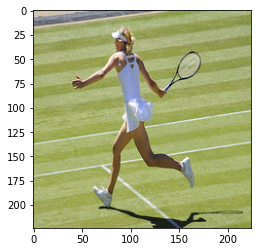

In [27]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
img = Image.open("inference_images/img1.jpg").convert('RGB')
img = img.resize((224,224), Image.ANTIALIAS)
plt.imshow(img)
img = transform(img)
input_img = torch.unsqueeze(img, dim=0)

In [28]:
# get image and question
qst_str = "what sport is she playing?"
qst_tokens = text_helper.tokenize(qst_str)

In [29]:
max_qst_length = 30  # or 26

qst_vocab = text_helper.VocabDict('datasets/vocab_questions.txt')

qst2idc = np.array([qst_vocab.word2idx('<pad>')] * max_qst_length)  # padded with '<pad>' in 'ans_vocab'
qst2idc[:len(qst_tokens)] = [qst_vocab.word2idx(w) for w in qst_tokens]

input_qst = torch.from_numpy(qst2idc).long()
input_qst = torch.unsqueeze(input_qst, dim=0)

In [30]:
output = model(input_img, input_qst)

In [31]:
_, ans = torch.max(output, 1)  # [batch_size]

def load_str_list(fname):
    with open(fname) as f:
        lines = f.readlines()
    lines = [l.strip() for l in lines]
    return lines

word_list = load_str_list('datasets/vocab_answers.txt')

In [32]:
word_list[ans.item()]

'tennis'